In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, utils as ut, plot as pp
from mintpy import tsview, timeseries2velocity as ts2vel
plt.rcParams.update({'font.size': 12})

proj_dicts = [
    {'ts_file' : os.path.expanduser('~/data/geolocation/ChileSenDT156/mintpy_offset/timeseriesRg_gimTEC_SET_ERA5.h5'),
     'lalo'    : [-21.30, -67.39],
    },
    {'ts_file' : os.path.expanduser('~/data/offset4motion/SaltonSeaSenDT173/mintpy_offset_v2/timeseriesRg_SET_ERA5.h5'),
     'lalo'    : [32.82, -116.05],
    },
]

work_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src/S1AB')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1AB


In [2]:
def read_data(ts_file, lalo):
    proj_dir = os.path.dirname(ts_file)
    lookup_file = os.path.join(proj_dir, 'inputs/geometryRadar.h5')

    # read data
    dates, ts_dis = ut.read_timeseries_lalo(lat=lalo[0], lon=lalo[1], ts_file=ts_file, lookup_file=lookup_file, print_msg=False)
    ts_dis *= 100  # m -> cm

    # dates/flags for S1AB
    date_listA = np.loadtxt(os.path.join(proj_dir, 'S1A_date.txt'), dtype=str).tolist()
    date_listB = np.loadtxt(os.path.join(proj_dir, 'S1B_date.txt'), dtype=str).tolist()
    date_list = sorted(date_listA + date_listB)
    min_date = date_listB[0] # '20160101' # date_listB[0]
    flagA = np.array([x in date_listA and x >= min_date for x in date_list], dtype=np.bool_)
    flagB = np.array([x in date_listB and x >= min_date for x in date_list], dtype=np.bool_)

    return dates, ts_dis, flagA, flagB, date_list

ChileSenDT156
  S1A:
    # of dates: 77
    model param: [8.953229 3.193807]
  S1B:
    # of dates: 97
    model param: [16.103975   3.4683006]
  Bias est.: 7.2 cm
SaltonSeaSenDT173
  S1A:
    # of dates: 42
    model param: [7.260098  1.3933876]
  S1B:
    # of dates: 43
    model param: [20.76005   -1.6627839]
  Bias est.: 13.5 cm
save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/S1AB/S1AB_bias.pdf


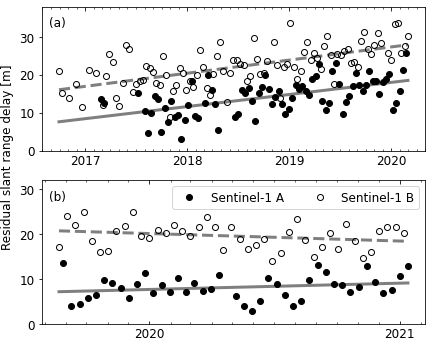

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6, 5])
for ax, proj_dict in zip(axs, proj_dicts):
    ts_file = proj_dict['ts_file']
    lalo = proj_dict['lalo']
    proj_name = os.path.basename(os.path.dirname(os.path.dirname(ts_file)))

    # read data
    dates, ts_dis, flagA, flagB, date_list = read_data(ts_file, lalo)
    date_listA = np.array(date_list)[flagA].tolist()
    date_listB = np.array(date_list)[flagB].tolist()
    min_date = sorted(date_listA + date_listB)[0]

    # fit
    model = dict(polynomial=1)
    GA, mA, e2A = ts2vel.estimate_time_func(model, date_listA, ts_dis[flagA], ref_date=date_listA[0])
    GB, mB, e2B = ts2vel.estimate_time_func(model, date_listB, ts_dis[flagB], ref_date=date_listB[0])

    date_list_fit = ptime.get_date_range(min_date, date_list[-1])
    dates_fit = ptime.date_list2vector(date_list_fit)[0]
    GA_fit = timeseries.get_design_matrix4time_func(date_list_fit, model, refDate=date_listA[0])
    GB_fit = timeseries.get_design_matrix4time_func(date_list_fit, model, refDate=date_listB[0])
    ts_fitA = np.matmul(GA_fit, mA)
    ts_fitB = np.matmul(GB_fit, mB)
    print(f'{proj_name}')
    print('  S1A:')
    print('    # of dates: {}'.format(np.sum(flagA)))
    print('    model param: {}'.format(mA))
    print('  S1B:')
    print('    # of dates: {}'.format(np.sum(flagB)))
    print('    model param: {}'.format(mB))
    print('  Bias est.: {:.1f} cm'.format(mB[0] - mA[0]))

    # plot
    cs = ['k', 'k']
    ax.plot(dates[flagA], ts_dis[flagA], 'o', color=cs[0], mfc=cs[0],  ms=6, label='Sentinel-1 A')
    ax.plot(dates[flagB], ts_dis[flagB], 'o', color=cs[1], mfc='none', ms=6, label='Sentinel-1 B')
    ax.plot(dates_fit, ts_fitA, '-',  color=cs[0], alpha=0.5, lw=3)
    ax.plot(dates_fit, ts_fitB, '--', color=cs[1], alpha=0.5, lw=3)
    # axis format
    ax.tick_params(which='both', axis='x', direction='in', top=True, bottom=True)
    pp.auto_adjust_xaxis_date(ax, dates[flagB], buffer_year=None)

# axis format
axs[0].set_ylim(0, 38)
axs[1].set_ylim(0, 32)
axs[1].legend(ncol=2)
fig.tight_layout()
plt.annotate('Residual slant range delay [m]', xy=(0.002, 0.55), xycoords='figure fraction', va='center', rotation='vertical')
for ax, num, yloc in zip(axs, ['(a)', '(b)'], [0.12, 0.8]):
    ax.annotate(num, xy=(0.02, 0.86), xycoords='axes fraction', ha='left')

# output
out_fig = os.path.join(work_dir, 'S1AB_bias.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()